## Nu.nl Convert Data

Convert nu.nl data to text data format

Each month run ../../scripts/combineNunlComments.sh to include the comments in the existing set

In [1]:
import datetime
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import clear_output

In [2]:
BASEDIR = "../data/nunl/"
DATADIRIN = BASEDIR+"downloads/"
DATADIRTEXT = BASEDIR+"text/"
FILEPATTERN = r".csv$"
DATEPATTERNIN = "%m/%d/%Y, %I:%M:%S %p"
DATEPATTERNOUT = "%Y%m%d-%H"
FILESUFFIX = ".out.gz"
DATE = "date"
TEXT = "text"
NAME = "name"
ID = "id"
IDSTR = "id_str"
PARENT = "parent"
REPLYID = "in_reply_to_status_id_str"
USER = "user"
VERIFIED = "verified"

In [3]:
def squeal(text=None):
    clear_output(wait=True)
    if not text is None: print(text)

## Get all comments from downloaded files

In [4]:
idStr = ""
replyId = ""
verified = ""
dataPerHour = {}
inFileNames = sorted(os.listdir(DATADIRIN))
monthCounts = {}

for inFileName in inFileNames:
    if re.search(FILEPATTERN,inFileName):
        squeal(inFileName)
        try:
            dfIn = pd.read_csv(DATADIRIN+inFileName)
        except:
            continue
        for i in range(0,len(dfIn)):
            try:
                hourStringComplete = dfIn.iloc[i][DATE]
                date = datetime.datetime.strptime(hourStringComplete,DATEPATTERNIN)
                hourStringHour = date.strftime(DATEPATTERNOUT)
            except: break
            if not hourStringHour in dataPerHour: dataPerHour[hourStringHour] = []
            dataPerHour[hourStringHour].append(dfIn.iloc[i])
            month = hourStringHour[0:6]
            if not month in monthCounts: monthCounts[month] = 0
            monthCounts[month] += 1

wielrennen-6080868.csv


In [5]:
for month in sorted(monthCounts.keys()):
    print(f"{month}: {monthCounts[month]}")

202001: 5675
202002: 25721
202003: 207957
202004: 193530
202005: 146832
202006: 90698
202007: 85085
202008: 105047
202009: 114480
202010: 10549


## Store all comments in hour files

In [6]:
for hourString in sorted(dataPerHour.keys()):
    squeal(hourString)
    outFileName = hourString+FILESUFFIX
    if len(dataPerHour[hourString]) > 0:
        dfOut = pd.DataFrame(dataPerHour[hourString]).rename(columns={ID:IDSTR,NAME:USER,PARENT:REPLYID})
        del(dfOut[DATE])
        dfOut[VERIFIED] = ["" for i in range(0,len(dfOut))]
        dfOut.to_csv(DATADIRTEXT+outFileName,index=False,compression="gzip")

20201003-14


## Visualize number of comments per day

In [7]:
def movingAverage(numberList,size):
    newList = []
    for i in range(0,len(numberList)):
        numberUsed = 1
        newList.append(numberList[i])
        for j in range(1,size):
            if i-j >= 0:
                newList[i] += numberList[i-j]
                numberUsed += 1
        newList[i] /= numberUsed
    return(newList)

In [8]:
def fileNameToHourString(fileName):
    return(fileName[0:11])

dataPerHour = {}
inFileNames = sorted(os.listdir(DATADIRTEXT))
for inFileName in inFileNames:
    squeal(inFileName)
    hourString = fileNameToHourString(inFileName)
    df = pd.read_csv(DATADIRTEXT+inFileName).rename(columns={IDSTR:ID,USER:NAME,REPLYID:PARENT})
    dataPerHour[hourString] = list(df.T.to_dict(orient="dict").values())

20201003-14.out.gz


In [9]:
countsPerDate = {}
for hourString in sorted(dataPerHour.keys()):
    dateString = hourString[0:8]
    if not dateString in countsPerDate: countsPerDate[dateString] = 0
    countsPerDate[dateString] += len(dataPerHour[hourString])

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/home/erikt/anaconda3/envs/python37/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


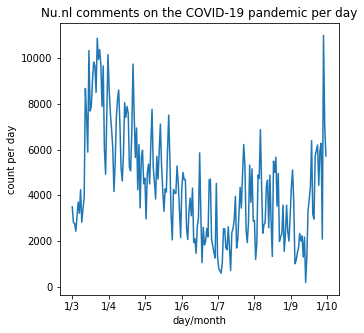

In [10]:
DATEFORMATDAY = "%Y%m%d"
PLOTFILENAME = "frequency-nunl.png"
COMBINEDDAYS = 1
FINALDATE = "20200930"
FIRSTDATE = "20200301"

x = [datetime.datetime.strptime(d,DATEFORMATDAY) for d in countsPerDate if d >= FIRSTDATE and d <= FINALDATE]
y = [countsPerDate[d] for d in countsPerDate if d >= FIRSTDATE and d <= FINALDATE]

fig,ax = plt.subplots(figsize=(5,5))
plt.plot_date(x,movingAverage(y,COMBINEDDAYS),fmt="-")
plt.xlabel("day/month")
plt.ylabel("count per day")
title = "Nu.nl comments on the COVID-19 pandemic per day"
if COMBINEDDAYS > 1: title += f" (average over {COMBINED} days)"
plt.title(title)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m"))
plt.savefig(PLOTFILENAME)
plt.show()

## Visualize query words

In [11]:
TOPIC = "topic"
QUERYLIST = ("corona covid mondkapje rivm blijfthuis houvol huisarts flattenthecurve "+TOPIC).split()
QUERYTOPIC = "corona|covid|mondkapje|rivm|blijfthuis|houvol|huisarts|flattenthecurve"
TOTAL = "total"

def makeDateFromHour(hour):
    return(hour[0:8])

queryCounts = {}
for query in QUERYLIST:
    queryCounts[query] = {}
    querySearch = query
    if query == TOPIC: querySearch = QUERYTOPIC
    for hourString in sorted(dataPerHour.keys()):
        date = makeDateFromHour(hourString)
        if re.search("-12$",hourString): squeal(date+" "+query)
        for i in range(0,len(dataPerHour[hourString])):
            if re.search(querySearch,dataPerHour[hourString][i][TEXT],flags=re.IGNORECASE):
                if not date in queryCounts[query]: queryCounts[query][date] = 0
                queryCounts[query][date] += 1

queryCounts[TOTAL] = {}
for hourString in sorted(dataPerHour.keys()):
    date = makeDateFromHour(hourString)
    if re.search("-12$",hourString): squeal(date+" "+TOTAL)
    for i in range(0,len(dataPerHour[hourString])):
        if not date in queryCounts[TOTAL]: queryCounts[TOTAL][date] = 0
        queryCounts[TOTAL][date] += 1

totals = {}
for query in QUERYLIST+[TOTAL]:
    totals[query] = sum(queryCounts[query].values())

20201003 total


In [12]:
def movingAverage(numberList,size):
    newList = []
    for i in range(0,len(numberList)):
        numberUsed = 1
        newList.append(numberList[i])
        for j in range(1,size):
            if i-j >= 0:
                newList[i] += numberList[i-j]
                numberUsed += 1
        newList[i] /= numberUsed
    return(newList)

In [13]:
WEEKSIZE = 7

queryCounts7 = {}
for query in QUERYLIST:
    try:
        sortedKeys = list(sorted(queryCounts[query].keys()))
        sortedValues = [queryCounts[query][d] for d in sortedKeys]
        newSortedValues = movingAverage(sortedValues,WEEKSIZE)
        queryCounts7[query] = {sortedKeys[i]:newSortedValues[i] for i in range(0,len(sortedKeys))}
    except: pass

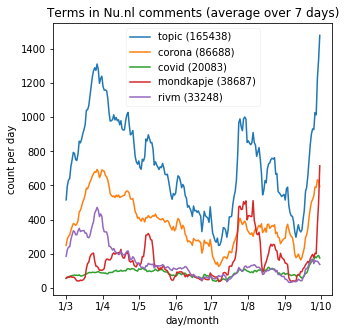

In [14]:
FINALDATE = "20200930"
FIRSTDATE = "20200301"
PLOTFILENAME = "term-frequency-nunl.png"

fig,ax = plt.subplots(figsize=(5,5))
for query in "topic corona covid mondkapje rivm".split():
    try:
        x = [datetime.datetime.strptime(d,DATEFORMATDAY) for d in queryCounts7[query] if d >= FIRSTDATE and d <= FINALDATE]
        y = [queryCounts7[query][d] for d in queryCounts7[query] if d >= FIRSTDATE and d <= FINALDATE]
        plt.plot_date(x,y,fmt="-",label=f"{query} ({totals[query]})")
    except: pass
plt.xlabel("day/month")
plt.ylabel("count per day")
plt.title(f"Terms in Nu.nl comments (average over {WEEKSIZE} days)")
plt.legend(framealpha=0.2)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m"))
plt.savefig(PLOTFILENAME)
plt.show()

In [15]:
NBROFCOMBINEDITEMS = 7

def summarizeXY(x,y,nbrOfCombinedItems=NBROFCOMBINEDITEMS):
    summarizedX = []
    summarizedY = []
    yCombined = 0
    for i in range(0,len(y)):
        yCombined += y[i]
        if (i+1)%nbrOfCombinedItems == 0:
            summarizedX.append(x[i])
            summarizedY.append(yCombined)
            yCombined = 0
    if len(y)%nbrOfCombinedItems != 0:
        summarizedX.append(x[i])
        summarizedY.append(yCombined)
    return(summarizedX,summarizedY)

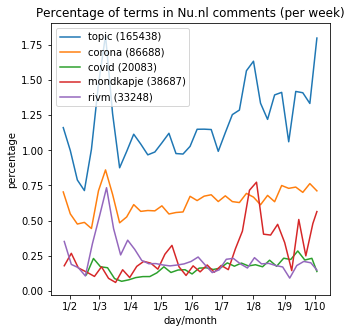

In [16]:
INITDAYSSKIPPED = 0
PLOTFILENAME = "term-percentages-nunl.png"

fig,ax = plt.subplots(figsize=(5,5))
for query in (TOPIC+" corona covid mondkapje rivm").split():
    try:
        x = [datetime.datetime.strptime(d,DATEFORMATDAY) for d in queryCounts7[query]][INITDAYSSKIPPED:]
        y = [queryCounts[query][d]/queryCounts[TOTAL][d] for d in queryCounts[query]][INITDAYSSKIPPED:]
        summarizedX,summarizedY = summarizeXY(x,y)
        plt.plot_date(summarizedX,summarizedY,fmt="-",label=f"{query} ({totals[query]})")
    except: pass
plt.xlabel("day/month")
plt.ylabel("percentage")
plt.title(f"Percentage of terms in Nu.nl comments (per week)")
plt.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m"))
plt.savefig(PLOTFILENAME)
plt.show()